# Requirements

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns 
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import * 
from xgboost import XGBRegressor

## Blood Pressure Analysis


# Dataset Description

## Attributes

* id - patient identifier
* age - patient age
* height - patient height in cm
* weight - patient weight in kg
* blood sugar - patient blood sugar level
* Cholesterol - patient cholesterol level
* triglyceride - patient triglyceride level
* HDL - patient high-density lipoprotein cholesterol level
* LDL - patient low-density lipoprotein cholesterol level
* hemoglobin - patient hemoglobin level
* Urine protein - patinet protein in urine level
* serum creatinine - patient serum creatinine level
* AST - patient aspartate aminotransferase level
* ALT - patient Alanine transaminase level
* Gtp - patient Guanosine-5'-triphosphate level
* dental caries - does patient have dental caries

### Target variable
* blood - patient systolic blood pressure

# Read the dataset

In [2]:
df = pd.read_csv('data/blood_pressure_data.csv')

In [3]:
df.shape

(10000, 18)

In [4]:
df.sample(5)

,id,age,height(cm),weight(kg),relaxation,blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,blood pressure
7302,82695.0,NaN,175.0,85.0,71.0,91.0,188.0,NORMAL,NaN,102.0,14.6,NaN,0.9,NaN,NaN,NaN,Yes,NaN
4109,NaN,9/4/1969,NaN,60.0,76.0,107.0,NaN,LOW,46.0,122.0,17.1,3.0,3.4,NaN,NaN,29.0,No,131.0
5163,NaN,4/26/1984,170.0,65.0,NaN,NaN,175.0,UNK,NaN,NaN,NaN,1.0,1.1,18.0,17.0,16.0,No,119.0
2082,83075.0,NaN,NaN,70.0,83.0,121.0,168.0,HiGH,50.0,83.0,15.3,1.0,NaN,28.0,23.0,43.0,No,116.0
9741,38376.0,2/24/1984,NaN,55.0,70.0,97.0,NaN,NaN,58.0,125.0,NaN,3.0,0.8,16.0,9.0,NaN,Yes,110.0


In [5]:
df.drop(columns=['id'], inplace=True)

In [6]:
birthdays = df['age'].to_list()

In [7]:
ages = []

for date in birthdays:
    if date is np.nan:
        ages.append(np.nan)
    else:
        year = int(date.split('/')[2]) 
        age = 2025 - int(year)
        ages.append(age)

In [8]:
df['age'] = ages

In [9]:
df.triglyceride.unique()

array([nan, 'LOW', 'NORMAL', 'HiGH', 'UNK', 'ABNORMAL'], dtype=object)

In [10]:
df['triglyceride'] = df['triglyceride'].replace({'UNK': np.nan})

In [11]:
df.iloc[[6551]]

,age,height(cm),weight(kg),relaxation,blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,blood pressure
6551,56.0,160.0,NaN,NaN,83.0,NaN,NaN,NaN,183.0,12.8,1.0,0.8,NaN,13.0,46.0,No,118.0


In [12]:
encoder = OrdinalEncoder()
df[['triglyceride']] = encoder.fit_transform(df[['triglyceride']])

In [13]:
warnings.filterwarnings('ignore', category=FutureWarning, message='Downcasting behavior in `replace` is deprecated')
df['dental caries'] = df['dental caries'].replace({"Yes": 1, "No": 0})

Explore the dataset using visualizations of your choice.

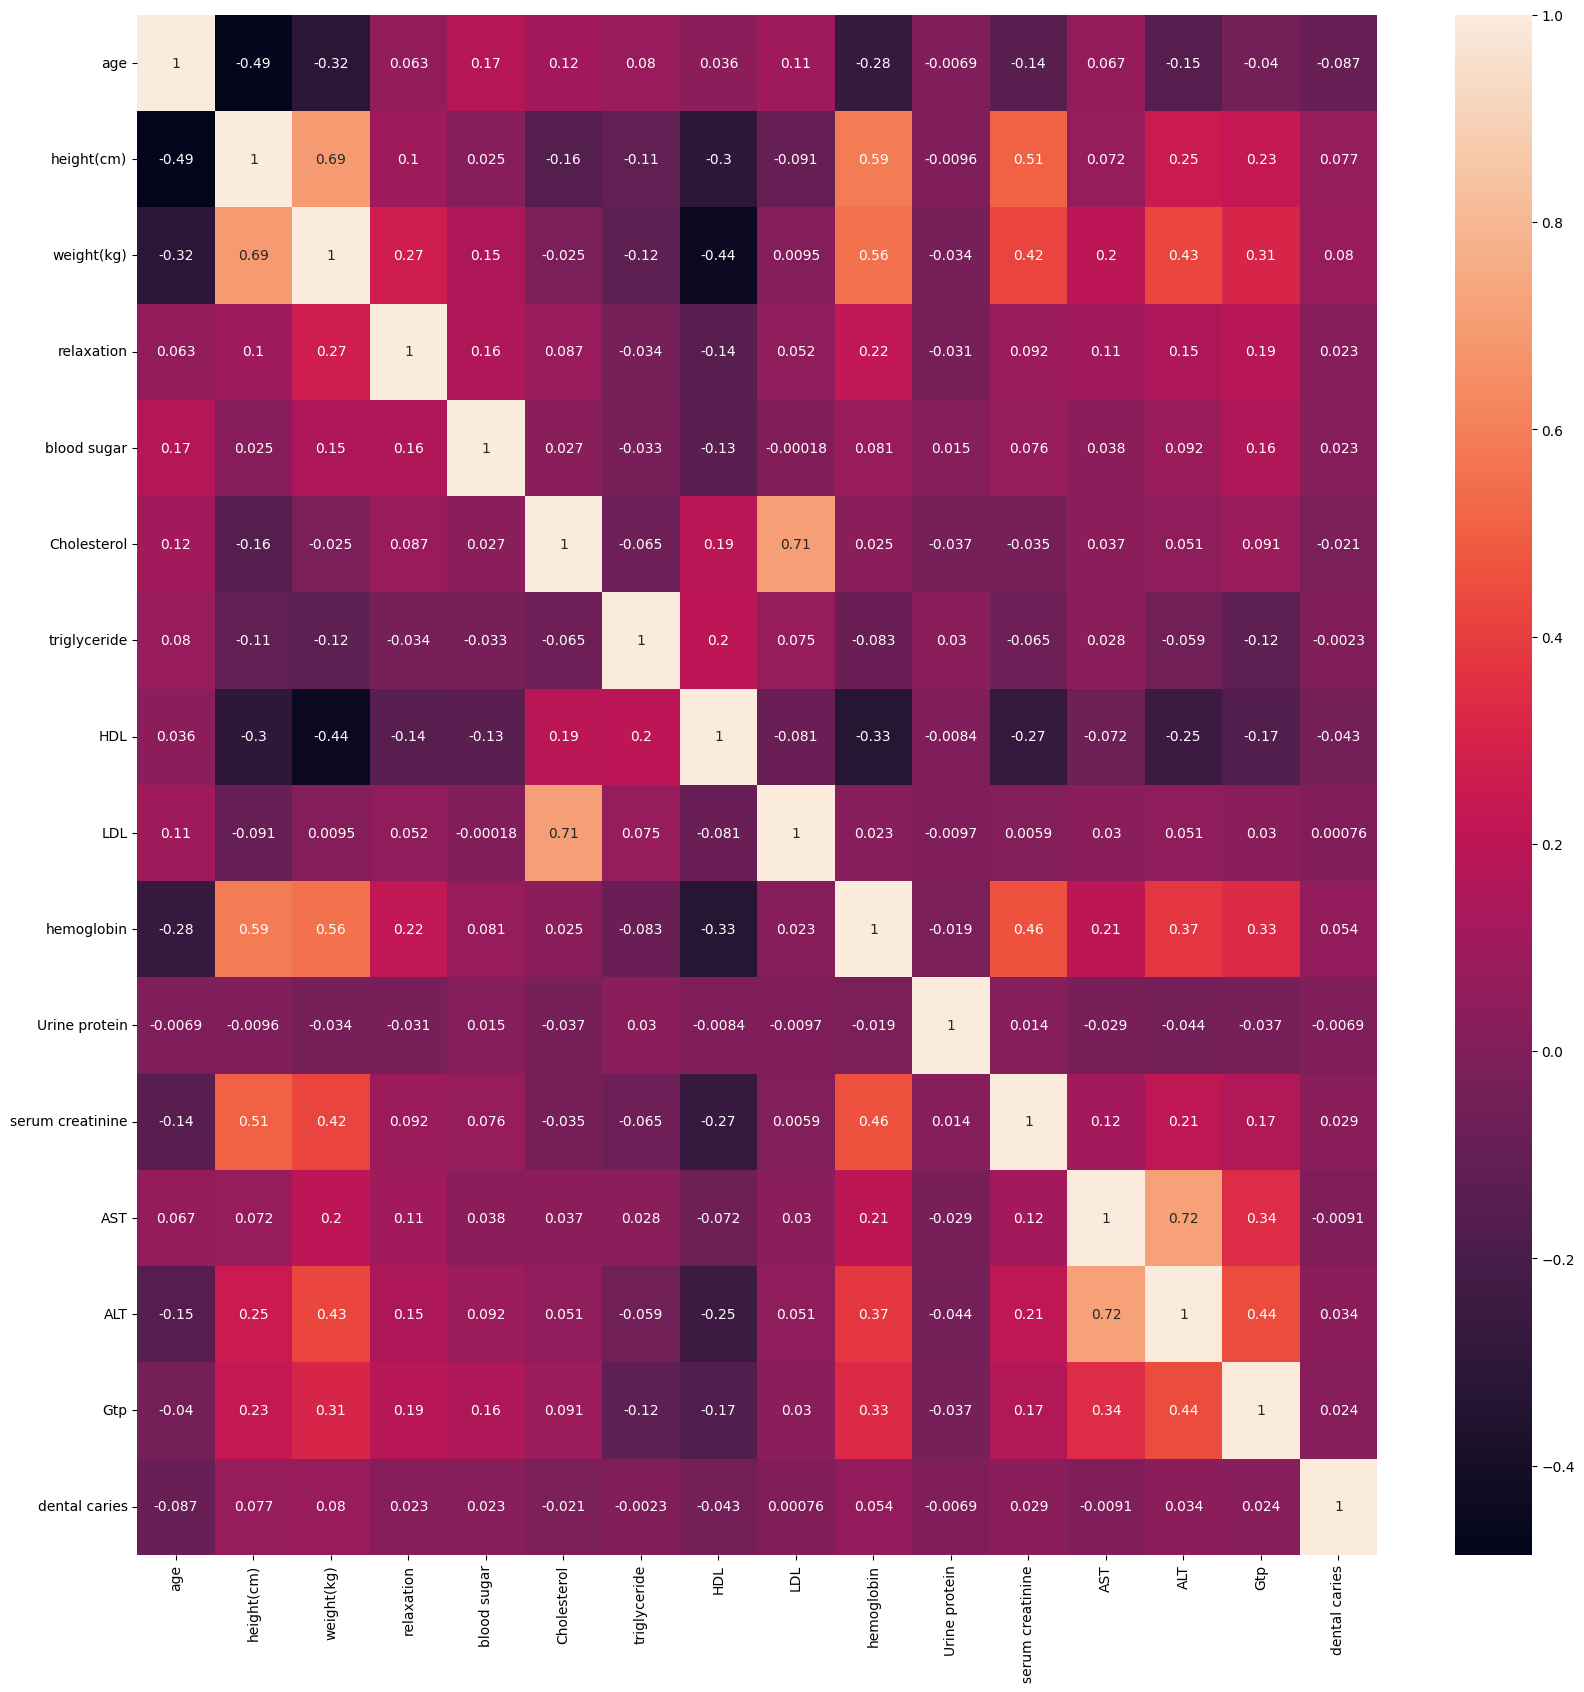

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(df.drop(columns='blood pressure').corr(), annot=True)
plt.show()

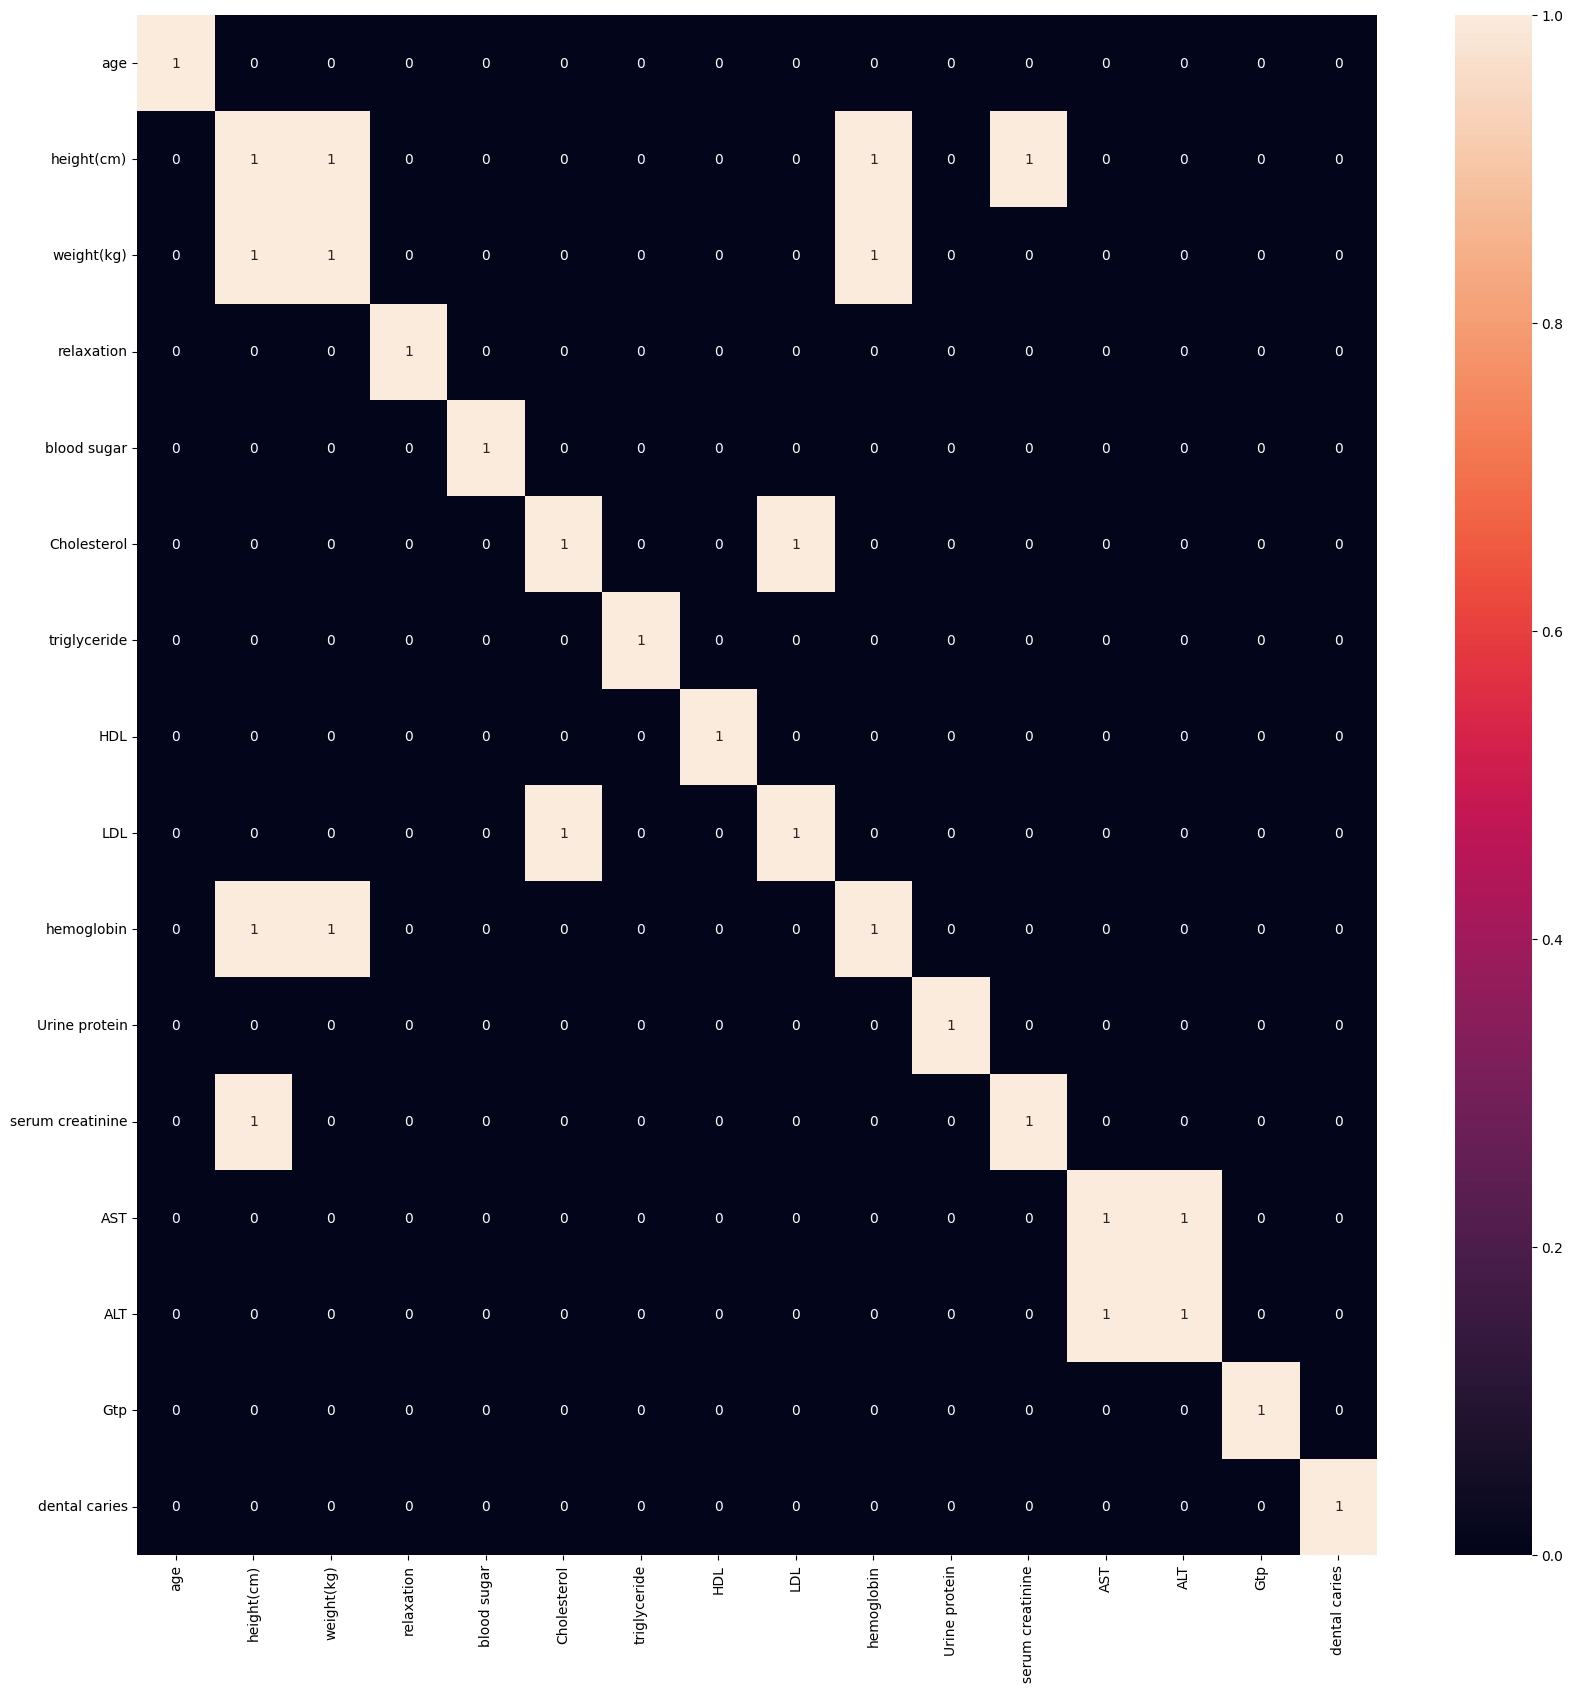

In [15]:
plt.figure(figsize=(20,20))
sns.heatmap(abs(df.drop(columns='blood pressure').corr())>0.5, annot=True)
plt.show()

## Detecting Missing Values
Calculate the percentage of missing values present in each column of the dataset.

In [16]:
df.isnull().sum()

age                 2688
height(cm)          2627
weight(kg)          2556
relaxation          2575
blood sugar         2562
Cholesterol         2614
triglyceride        2685
HDL                 2609
LDL                 2642
hemoglobin          2583
Urine protein       2525
serum creatinine    2567
AST                 2573
ALT                 2584
Gtp                 2589
dental caries          0
blood pressure      2523
dtype: int64

In [17]:
df.isnull().sum() / len(df) * 100

age                 26.88
height(cm)          26.27
weight(kg)          25.56
relaxation          25.75
blood sugar         25.62
Cholesterol         26.14
triglyceride        26.85
HDL                 26.09
LDL                 26.42
hemoglobin          25.83
Urine protein       25.25
serum creatinine    25.67
AST                 25.73
ALT                 25.84
Gtp                 25.89
dental caries        0.00
blood pressure      25.23
dtype: float64

## Understanding the Causes Behind Missing Values
Using visualization tools such as heatmaps, and dendrograms, illustrate the interdependence between attributes with missing values. Also, visualize the distribution of the missing values within the dataset using matrices and bar charts. To achieve this use the `missingno` library.

<Axes: >

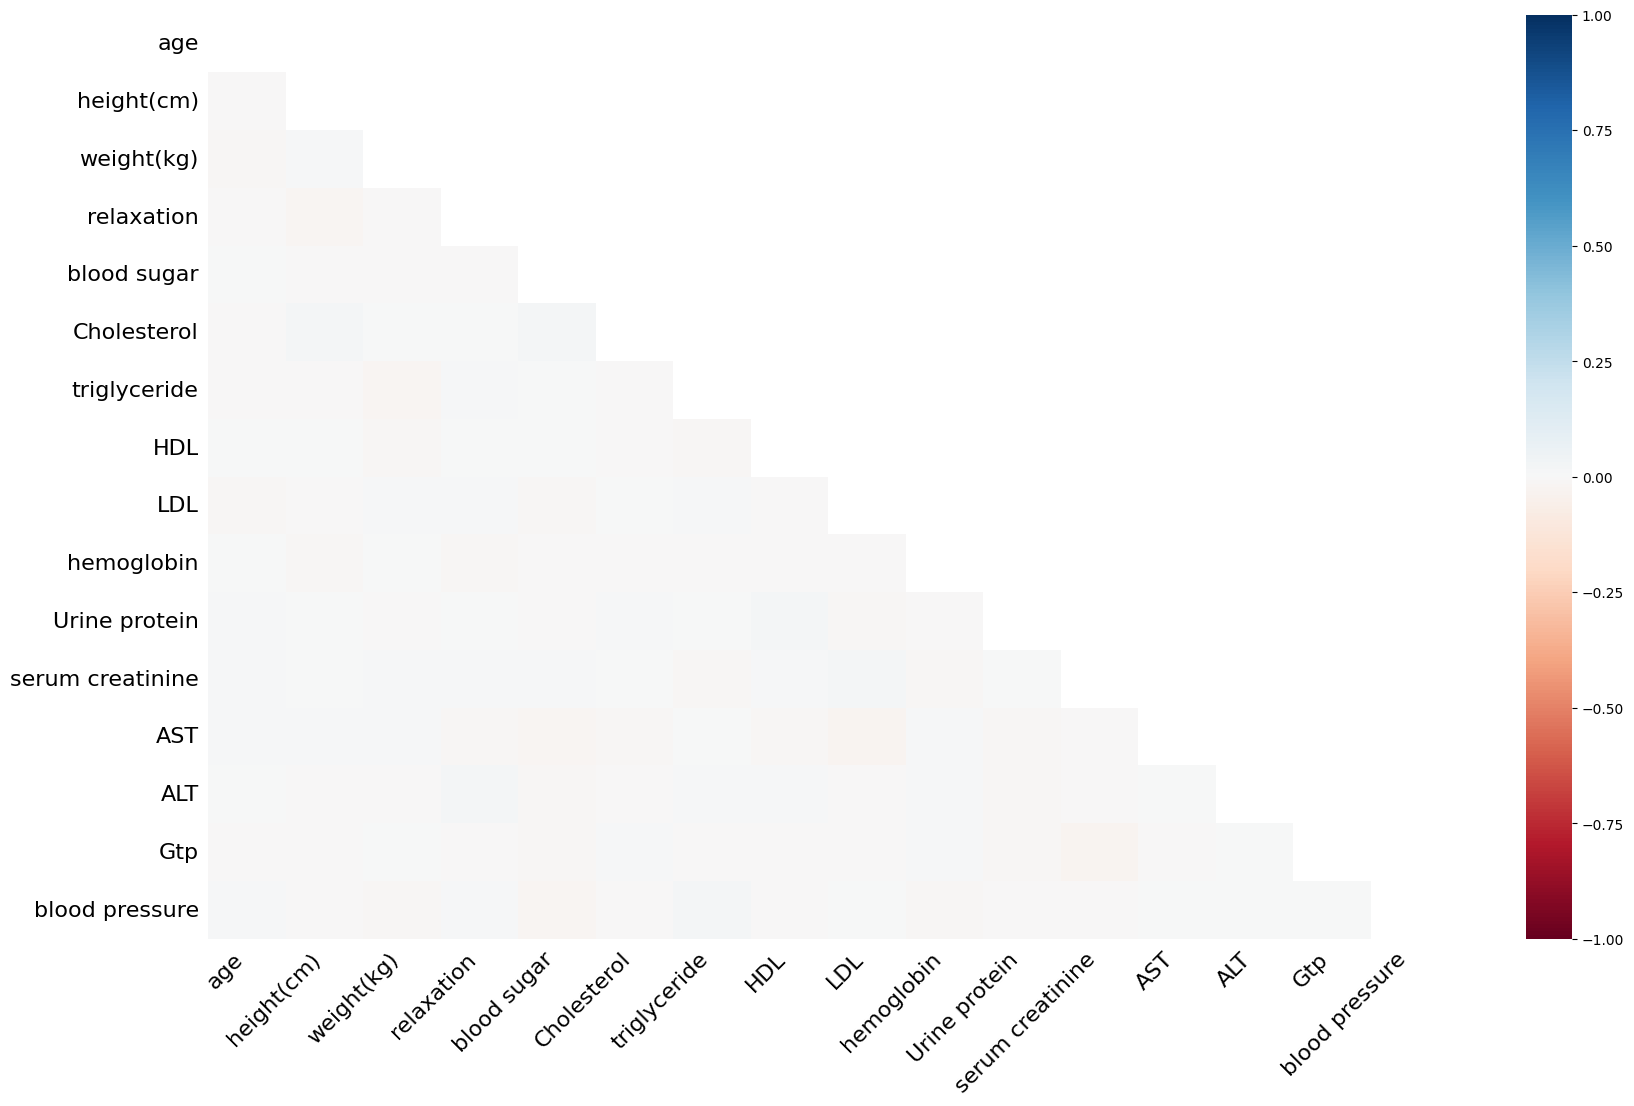

In [18]:
msno.heatmap(df)

<Axes: >

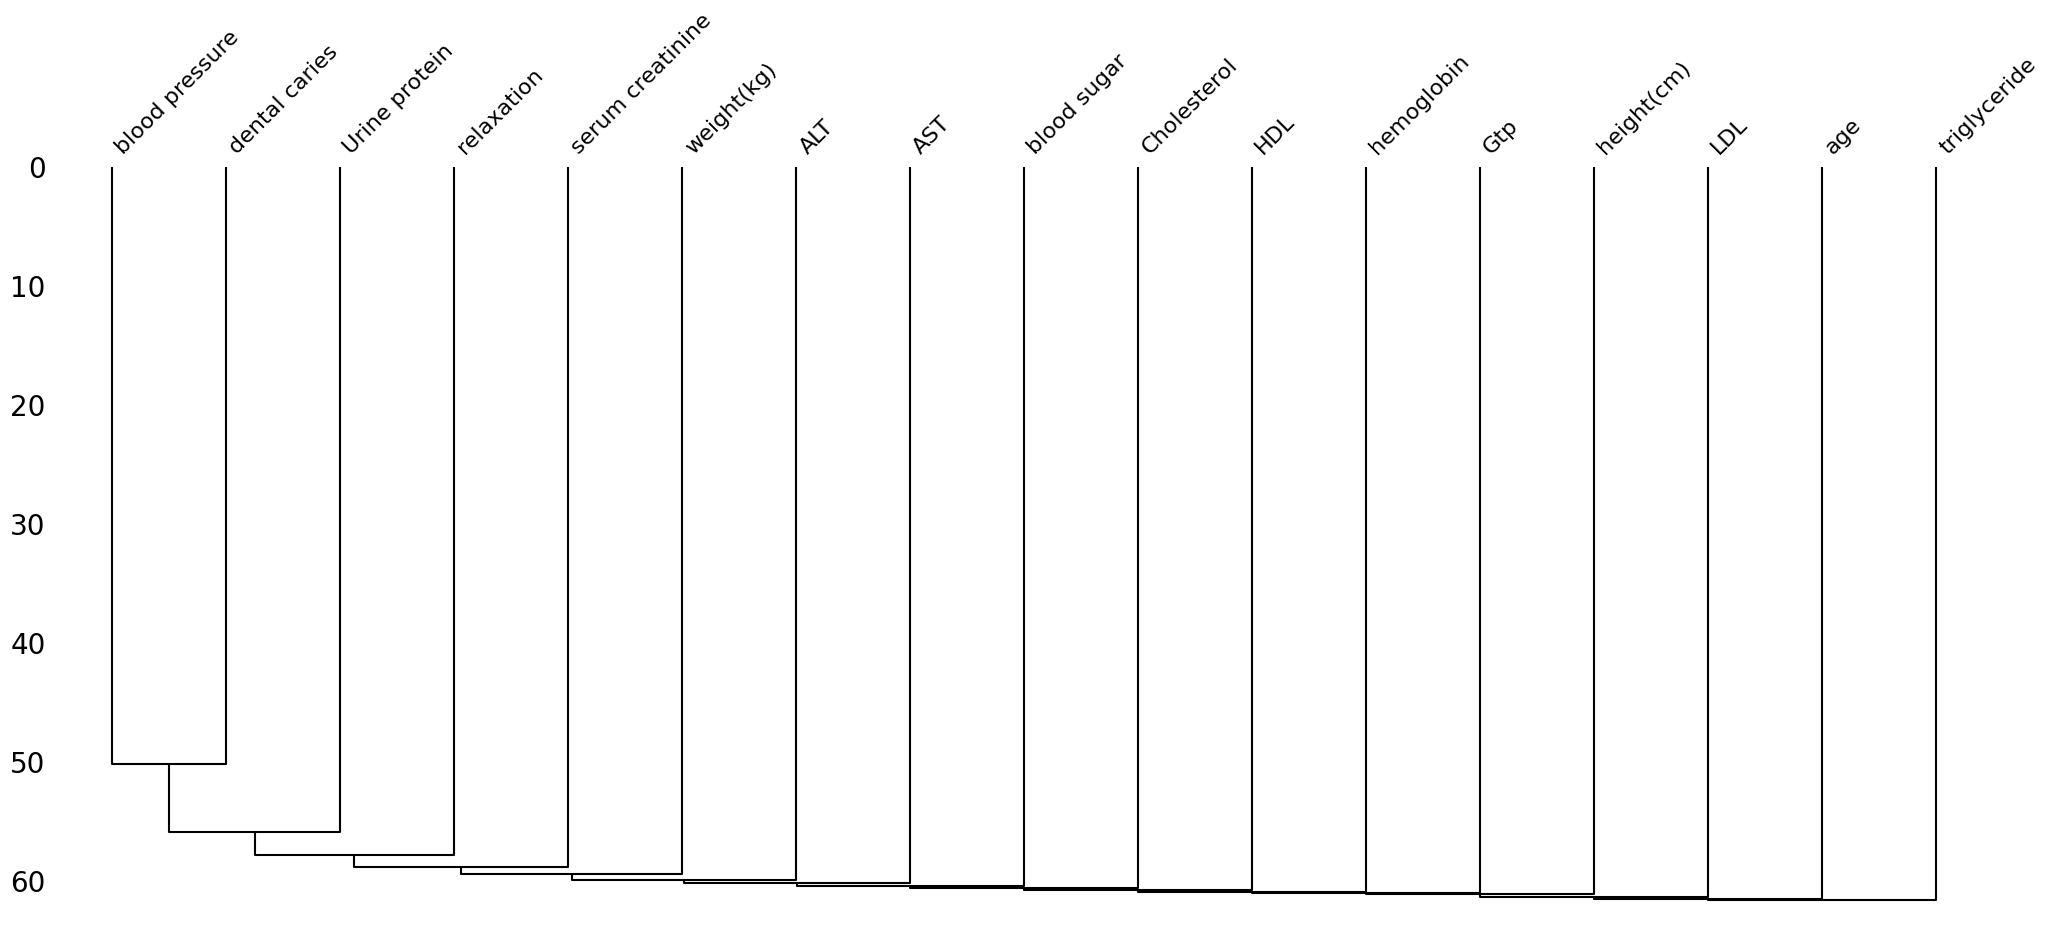

In [19]:
msno.dendrogram(df)

<Axes: >

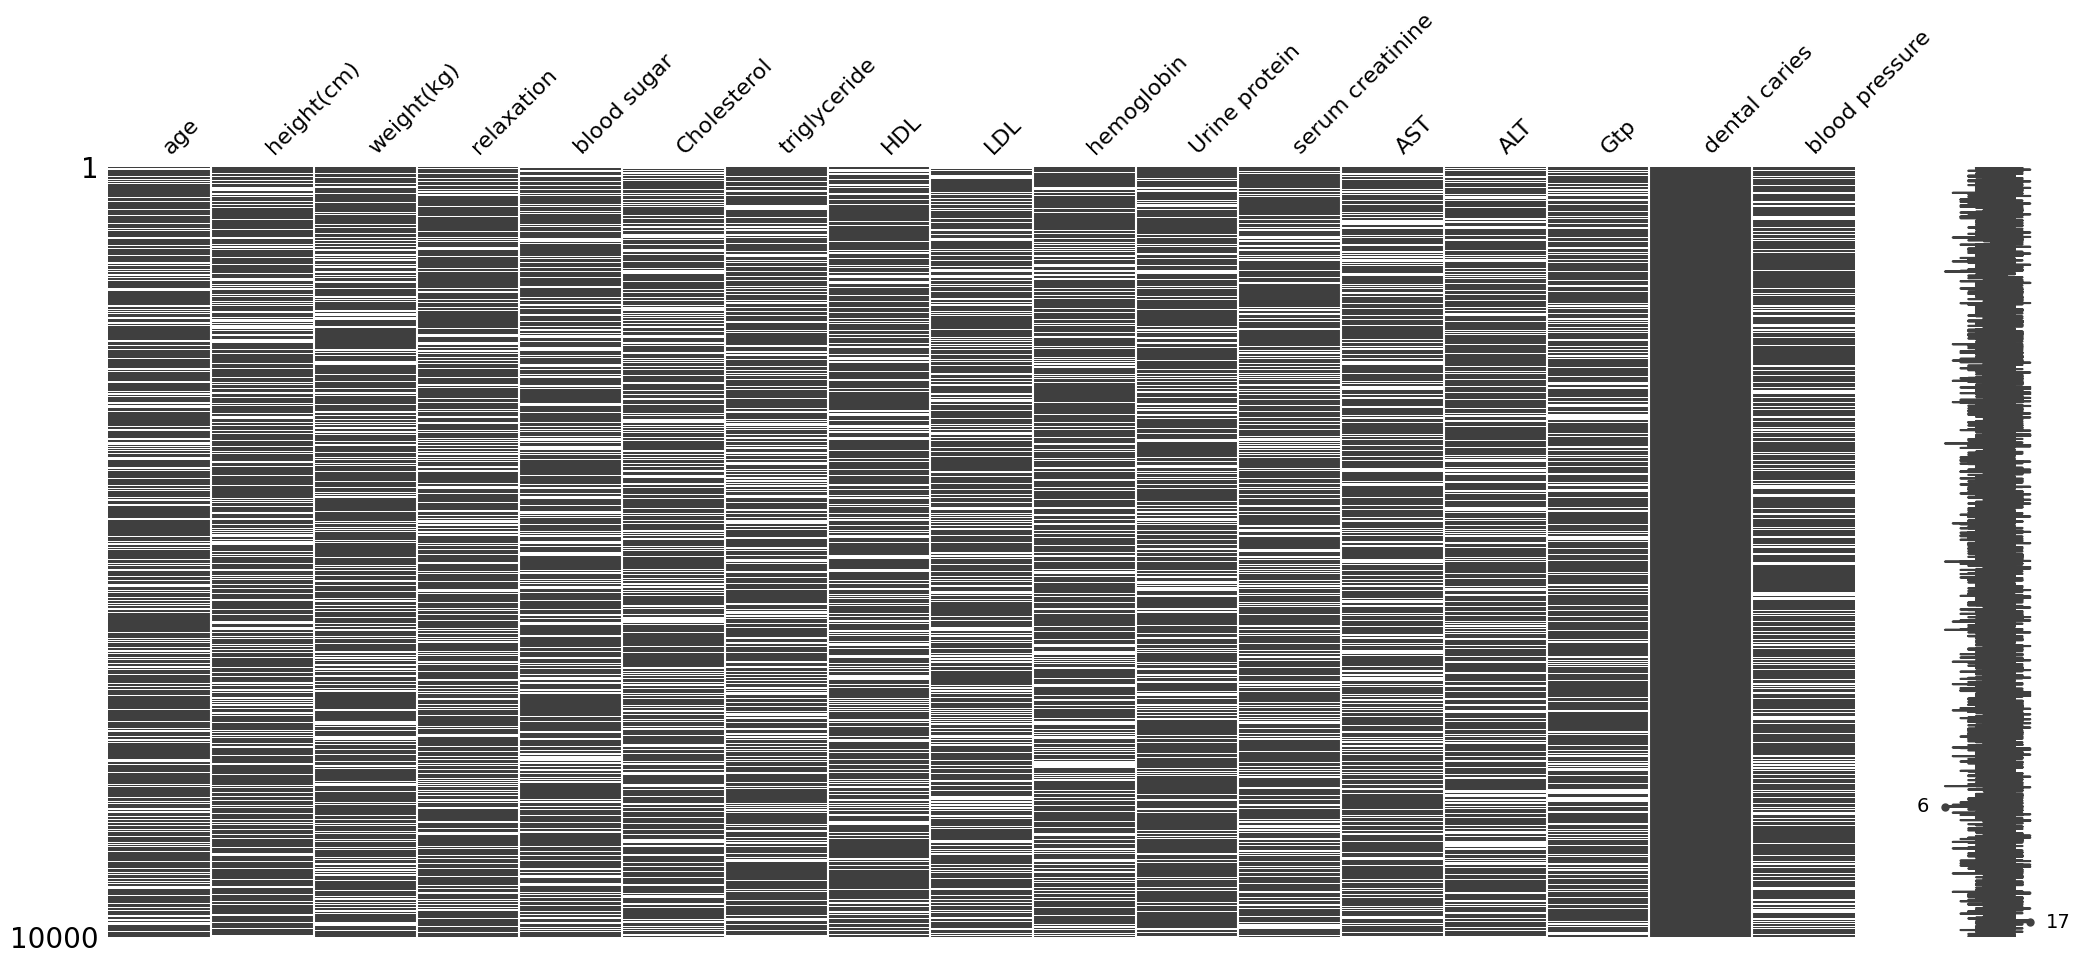

In [20]:
msno.matrix(df)

## Handling the Missing Values
Handle the missing values using suitable method based on the insights obtained from the various visualizations.

In [21]:
df.dropna(subset='blood pressure', inplace=True)

In [22]:
imputer = IterativeImputer()
values = imputer.fit_transform(df[['Cholesterol', 'LDL']])
df[['Cholesterol', 'LDL']] = values

In [23]:
df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'relaxation', 'blood sugar',
       'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin',
       'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp',
       'dental caries', 'blood pressure'],
      dtype='object')

In [24]:
imputer = IterativeImputer()
values = imputer.fit_transform(df[['height(cm)', 'weight(kg)', 'hemoglobin', 'serum creatinine']])
df[['height(cm)', 'weight(kg)', 'hemoglobin', 'serum creatinine']] = values

In [25]:
imputer = IterativeImputer()
values = imputer.fit_transform(df[['height(cm)', 'age']])
df[['height(cm)', 'age']] = values

In [26]:
imputer = IterativeImputer()
values = imputer.fit_transform(df[['HDL', 'weight(kg)']])
df[['HDL', 'weight(kg)']] = values

In [27]:
imputer = IterativeImputer()
values = imputer.fit_transform(df[['AST', 'ALT', 'Gtp']])
df[['AST', 'ALT', 'Gtp']] = values

<Axes: >

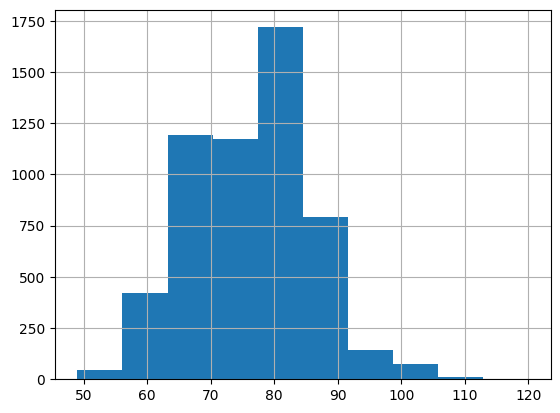

In [28]:
df['relaxation'].hist()

In [29]:
df['relaxation'] = df['relaxation'].fillna(df['relaxation'].median())

<Axes: >

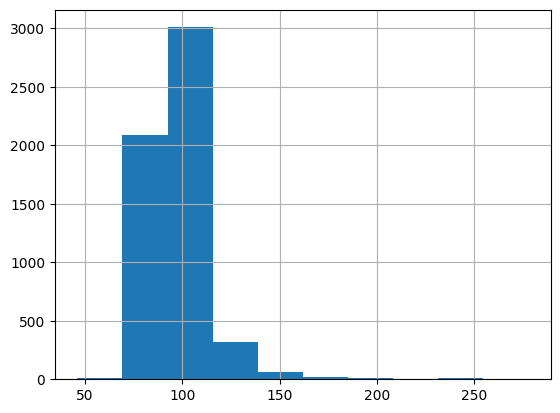

In [30]:
df['blood sugar'].hist()

In [31]:
df['blood sugar'] = df['blood sugar'].fillna(df['blood sugar'].median())

<Axes: >

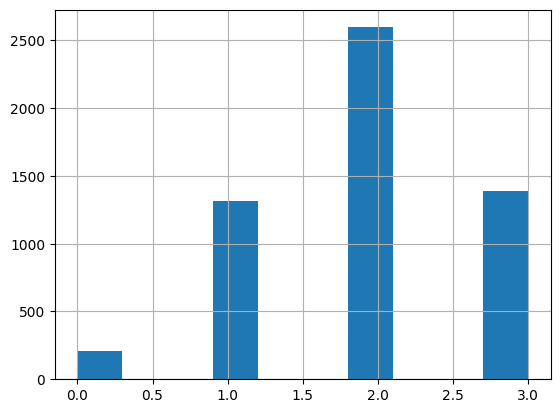

In [32]:
df['triglyceride'].hist()

In [33]:
df['triglyceride'] = df['triglyceride'].fillna(df['triglyceride'].mode()[0])

<Axes: >

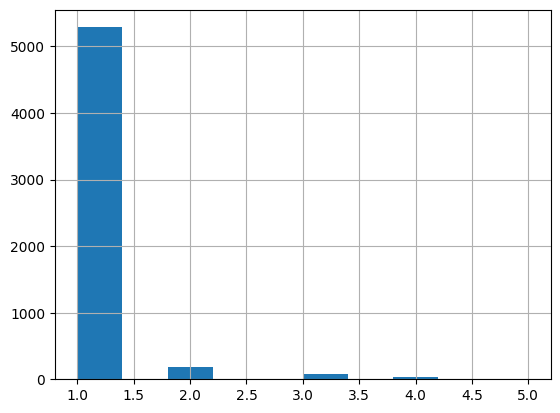

In [34]:
df['Urine protein'].hist()

In [35]:
df['Urine protein'] = df['Urine protein'].fillna(df['Urine protein'].mode()[0])

In [36]:
df.isnull().sum()

age                 0
height(cm)          0
weight(kg)          0
relaxation          0
blood sugar         0
Cholesterol         0
triglyceride        0
HDL                 0
LDL                 0
hemoglobin          0
Urine protein       0
serum creatinine    0
AST                 0
ALT                 0
Gtp                 0
dental caries       0
blood pressure      0
dtype: int64

## Feature Preprocessing


Preprocess the features to make them ready for using the model

In [37]:
X, y = df.drop(columns='blood pressure'), df['blood pressure']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

## Model comparison with cross-validation

Train two models: XGBoost and RandomForest for predicting the target variable. Use 5-fold cross-validation to evaluate the performance of the models and compare them using adrquate metrics.

In [40]:
xgb = XGBRegressor()

In [41]:
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [42]:
random_forest = RandomForestRegressor()

In [43]:
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Cross-Validation

#### XGBRegressor

In [51]:
kf = KFold(n_splits=5)
kf.get_n_splits(X, y)

5

In [52]:
xgb_param_grid ={
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2,3,4],
    'n_jobs': [7]
}

In [53]:
cv = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=kf, n_jobs=7)

In [54]:
cv.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    i...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=7,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 4], 'n_jobs': [7]})

In [55]:
cv.best_score_

0.469415778655743

In [56]:
model = cv.best_estimator_

In [57]:
y_pred = model.predict(X_test)

In [58]:
r2_score(y_test, y_pred)

0.517659105430109

#### RandomForestRegressor()

In [59]:
forest_param_grid = {
    'max_depth' :[2,3,4],
    'n_estimators': [50, 100, 500],
    'n_jobs': [7]
}

In [60]:
cv = GridSearchCV(estimator=random_forest, param_grid=forest_param_grid, cv=kf, n_jobs=7)

In [61]:
cv.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(), n_jobs=7,
             param_grid={'max_depth': [2, 3, 4], 'n_estimators': [50, 100, 500],
                         'n_jobs': [7]})

In [62]:
cv.best_score_

0.4486964752953238

In [63]:
model = cv.best_estimator_

In [64]:
y_pred = model.predict(X_test)

In [65]:
r2_score(y_test, y_pred)

0.4737839612507798